## Imports

In [1]:
!pip install PyWavelets

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
import skimage
import cv2
from sklearn.cluster import KMeans
from skimage.transform import resize
from tqdm import tqdm
from scipy.ndimage import uniform_filter
import pickle as pkl
import time

Prague Colour


In [3]:
data_path = "data/Prague_Colour_small/"
dataset_size = 20

imgs = [] ; masks = []
for i in range(1,dataset_size+1):
    imgs.append(skimage.io.imread(data_path + f'tm{i}_1_1.png'))
    masks.append(skimage.io.imread(data_path + f'mask{i}_1.png'))

## Abdulkadir Sengur, Yanhui Guo, 2011

### Utility functions (feature extraction)

In [34]:
W_size = 5
def mean_energy(band,window_size=W_size):
    """Mean energy with padding 0"""
    h,w = band.shape
    mean_energy = np.zeros((h,w))
    for i in range(h):
        for j in range(w):
            window = band[max(0,i-window_size//2):min(h,i+window_size//2),max(0,j-window_size//2):min(w,j+window_size//2)]
            # mean_energy[i,j] = (1/(window_size**2)) *np.sum(band[window])
            mean_energy[i,j] = np.mean(window*window)
    return mean_energy

def norm(vec):
    return (vec-vec.min())/(vec.max()-vec.min())

def local_mean(img,window_size=W_size):
    h,w = img.shape
    g= np.zeros((h,w))
    for i in range(h):
        for j in range(w):
            window = img[max(0,i-window_size//2):min(h,i+window_size//2+1),max(0,j-window_size//2):min(w,j+window_size//2+1)]
            g[i,j] = np.mean(window)
    return g

def img_to_NS(img,window_size=W_size):
    g= uniform_filter(img,window_size,output="float64",mode='reflect')
    delta = np.abs(img-g)
    T = (g - g.min())/(g.max()-g.min())
    I = norm(delta)
    F = 1 - T
    return T, I, F

def compute_alpha_beta(img,alpha_min=0.01,alpha_max=0.1,e_min=0):
    h,w = img.shape
    e = entropy(img)
    e_max = -1/h/w
    alpha = alpha_min + ((alpha_max-alpha_min)*(e-e_min))/(e_max-e_min)
    beta = 1-alpha
    return alpha, beta
def pixel_probability(I, bins=256):
    hist, _ = np.histogram(I.ravel(), bins=bins, range=(0,1), density=True)
    p = hist / np.sum(hist)
    return p[p > 0]

def entropy(img,bins=256):
    hist, _ = np.histogram(img.flatten(), bins=bins, range=(0,1), density=True)
    p = hist / np.sum(hist)
    p = p[p>0]
    return -np.sum(p*np.log2(p))

def entropy_NS(img):
    e = 0
    for ch in img:
        e+= entropy(img[ch])
    return e

def alpha_mean(img_NS,alpha=0.25,window_size=W_size):
    """"""
    mask = img_NS[1]>=alpha
    g_T,g_F = uniform_filter(img_NS[0],window_size,output="float64",mode='reflect'), uniform_filter(img_NS[2],window_size,output="float64",mode='reflect')
    T_alpha, F_alpha = img_NS[0].copy(),img_NS[2].copy()
    T_alpha[mask], F_alpha[mask] = g_T[mask], g_F[mask]
    g_g_T = uniform_filter(g_T,window_size,output="float64",mode='reflect')
    I_alpha = norm(np.abs(g_T-g_g_T))
    return T_alpha, I_alpha , F_alpha

def beta_enhancement(img_NS,beta=0.85,window_size=W_size):
    """Increase T contrast for segmentation"""
    mask = img_NS[1]>=beta
    T_prime = np.where(img_NS[0]<=0.5,2*img_NS[0]**2,1-2*(1-img_NS[0])**2)
    F_prime = np.where(img_NS[2]<=0.5,2*img_NS[2]**2,1-2*(1-img_NS[2])**2)
    T_beta, F_beta = img_NS[0].copy(), img_NS[2].copy()
    T_beta[mask], F_beta[mask] = T_prime[mask], F_prime[mask]
    T_prime_mean = uniform_filter(T_prime,window_size,output="float64",mode='reflect')
    I_beta = norm(np.abs(T_prime-T_prime_mean))
    return T_beta,I_beta,F_beta


def c_kmeans(X, K, max_iter=300, random_state=0):
    """
    Apply c-K-means clustering on neutrosophic subset X
    """
    w,h,p = X.shape
    X_flat = X.reshape(-1, p)

    kmeans = KMeans(
        n_clusters=K,
        max_iter=max_iter,
        random_state=random_state,
        n_init=10
    )
    labels = kmeans.fit_predict(X_flat)
    centers = kmeans.cluster_centers_.flatten()

    # Objective function J_TC
    JTC = 0.0
    for k in range(K):
        cluster_points = X_flat[labels == k]
        JTC += np.sum((cluster_points - centers[k]) ** 2)

    return labels.reshape((w,h)), centers, JTC


def NXB_K(JTC, centers, n_samples):
    """neutrosophic Xie-Beni index"""
    K = len(centers)

    # Minimum squared distance between cluster centers
    min_dist = np.inf
    for i in range(K):
        for j in range(i + 1, K):
            dist = (centers[i] - centers[j]) ** 2
            min_dist = min(min_dist, dist)

    return JTC / (n_samples * min_dist)

def find_optimal_K(X, K_range):
    """
    Select optimal K using neutrosophic Xie-Beni index
    """
    n_samples = X.size
    best_K = None
    best_score = np.inf

    for K in K_range:
        _, centers, JTC = c_kmeans(X, K)
        score = NXB_K(JTC, centers, n_samples)

        if score < best_score:
            best_score = score
            best_K = K

    return best_K, best_score

### utility functions (visualization)

In [5]:
## to view a single image
def imview(image, cmap="gray", interpolation="nearest",figsize=(6,6)):
    plt.figure(figsize=figsize)
    plt.imshow(image,cmap=cmap, interpolation=interpolation)
    plt.axis('off')
    plt.show()
    
## to view 3 images at once
def viewlist(images,cmap="gray", figsize=(18,6)):
    plt.figure(figsize=figsize)
    columns = len(images)
    for i, image in enumerate(images):
        plt.subplot(3, columns//3+1, i + 1)
        plt.imshow(image,cmap=cmap)
        plt.axis('off')
    plt.show()

def plot_comparison(original, filtered, name_left="im1", name_right="im2",cmap1="gray",cmap2="gray"):

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,18), sharex=True,
                                   sharey=False)
    ax1.imshow(original, cmap=cmap1,interpolation="nearest")
    ax1.set_title(name_left)
    ax1.axis('off')
    ax2.imshow(filtered, cmap=cmap2,interpolation="nearest")
    ax2.set_title(name_right)
    ax2.axis('off')

def plot_comparison_mask(original, mask,cmap1="gray"):
    original = (original - original.min())/(original.max()-original.min())
    out = np.stack([original]*3, axis=-1)
    out[mask==1] = [255,0,0]
    plt.figure(figsize=(18, 6))
    plt.imshow(out, cmap=cmap1,interpolation="nearest")
    # plt.imshow(mask,cmap=ListedColormap(['red']),alpha=0.6)
    plt.axis('off')

## constructing a random color map for segmentation display

from matplotlib import colors

r=np.random.rand ( 256,3)
r[0]=[0,0,0]

randcmap = colors.ListedColormap (r)

##### wavelets
'haar', 'db4', 'sym2'-'sym3', 'coif10', 'bior1.1', 'rbio1.3',

### Segmentation algorithm

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:03<00:00,  1.37it/s]
5it [00:07,  1.50s/it]
100%|██████████| 1/1 [00:37<00:00, 37.28s/it]


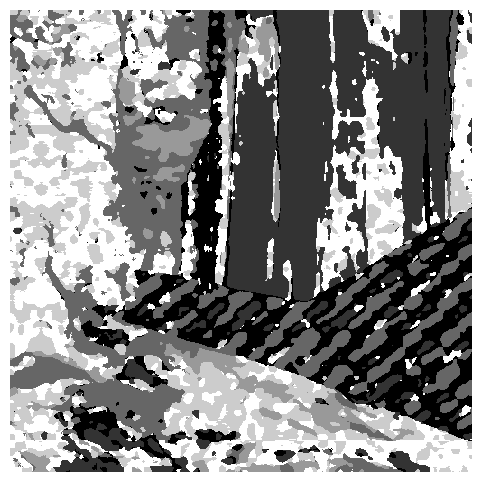

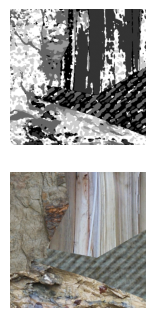

In [53]:
num_model=2
seg_imgs = []
eps = 1e-3 ###A CHECK
gamma = 20 ###A CHECK j'ai l'impression qu'entre 20 et 60 ça n'a pas bcp d'impact -> regarder avec une métrique
MAX_ITER = 10 
wavelet = pywt.Wavelet('coif10')
for img in tqdm(imgs[1:2]):
    w, h,_ = img.shape
    #Step 1 : Conversion into LUV color space and gray image
    L,u,v = cv2.split(cv2.cvtColor(img,cv2.COLOR_RGB2Luv)) #conversion RGB -> LUV
    gray_img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    #Step 2 :  Decomposition of the gray image into subands (only LH,HL used )
    _, (LH, HL, HH) = pywt.dwt2(gray_img, wavelet) #look at what it does
    #Step 3: Mean Energy calculation of LH and HL
    MEHL = resize(uniform_filter(HL,size=5,mode='reflect',output='float64'),(w,h),mode='reflect')
    MELH = resize(uniform_filter(LH,size=5,output='float64',mode='reflect'),(w,h),mode='reflect')
    # MEHH = resize(uniform_filter(HH,size=5,output='float64',mode='reflect'),(w,h),mode='reflect')
    #Step 4 : Transformation into NS domain
    L_NS = img_to_NS(L)
    u_NS = img_to_NS(u)
    v_NS = img_to_NS(v)
    MEHL_NS = img_to_NS(MEHL)
    MELH_NS = img_to_NS(MELH)
    # MEHH_NS = img_to_NS(MEHH)
    img_NS = [L_NS,u_NS,v_NS,MEHL_NS,MELH_NS]
    # img_NS.append(MEHH_NS)
    img_NS_aug = []
    #Step 6&7 : Caluclation of alpha and beta parameters and alpha_mean and beta_enhancement
    for channel in tqdm(img_NS):
        alpha,beta = compute_alpha_beta(channel[0])
        t1 = time.time()
        channel_NS = beta_enhancement(alpha_mean(channel),alpha,beta)
        t1 = time.time()
        img_NS_aug.append(channel_NS)
        t1 = time.time()
    for i,channel in tqdm(enumerate(img_NS_aug)):
        ent_i = entropy(channel[1])
        alpha,beta = compute_alpha_beta(channel[0])
        channel_NS = beta_enhancement(alpha_mean(channel),alpha,beta)
        ent_i_1 = entropy(channel_NS[1])
        nb_iter = 0
        while np.abs((ent_i_1 -ent_i))>eps and  nb_iter<MAX_ITER:
            alpha,beta = compute_alpha_beta(channel[0])
            channel_NS = beta_enhancement(alpha_mean(channel),alpha,beta)
            ent_i = ent_i_1
            ent_i_1 = entropy(channel_NS[1])
            nb_iter += 1
        if nb_iter>=MAX_ITER:
            print((np.abs(ent_i_1 -ent_i)/ent_i))
        img_NS_aug[i] = channel_NS
    # Step 8 : gamma clustering
    X = []
    for channel in img_NS_aug:
        g_T = uniform_filter(channel[0],size=5,output='float64',mode='reflect')
        X.append(np.where(channel[1]<=gamma,channel[0],g_T))
    #rajoute les coordonnées du pixel (n'est pas beaucoup mieux mais un peu quand même)
    # l_i = np.array([i for i in range(w) for j in range(h)]).reshape((w,h))/w
    # l_j = np.array([j for i in range(w) for j in range(h)]).reshape((w,h))/h
    # X.append(l_i)
    # X.append(l_j)
    X = np.dstack(X)
    best_K, score = find_optimal_K(X, range(2, 8))
    labels, centers, _ = c_kmeans(X, best_K)
    seg_imgs.append(labels)

# with(open(f"data/segmentation/features_{num_model}.pkl",'wb')) as file:
#     pkl.dump(X,file)
best_img = cv2.imread('data/segmentation/coif10_moy_loc_5_20.png')
imview(labels)
viewlist((labels,imgs[1]))
# cv2.imwrite(f"data/segmentation/labels_model{num_model}.png",labels)


# fig, axes = plt.subplots(ncols=3)
# idx = np.random.randint(0,20)
# axes[0].imshow(seg_imgs[idx], cmap='inferno') #cmap='tab10')
# axes[1].imshow(masks[idx])
# axes[2].imshow(imgs[idx])

# # F1 score
# F1 = []
# for i in range(len(seg_imgs)):
#     TP = np.sum((masks[i] == 1) & (seg_imgs[i] == 1))
#     FN = np.sum((masks[i] == 1) & (seg_imgs[i] == 0))
#     FP = np.sum((masks[i] == 0) & (seg_imgs[i] == 1))


#     F1.append(2*TP / (2*TP + FP + FN))

# print(f'Mean accuracy : {np.mean(F1)}')
# print(f'Accuracy std : {np.std(F1)}')


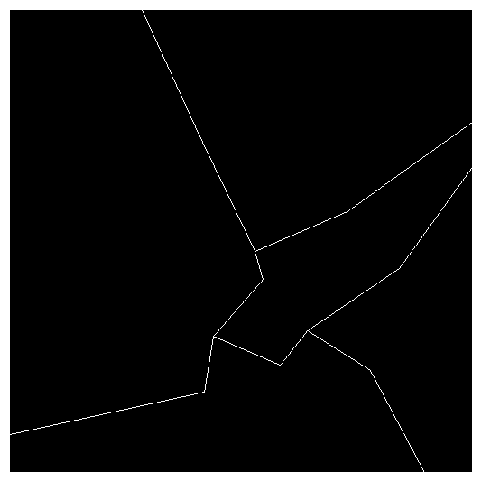

In [ ]:
### faire une fonction qui retourne le nombre de pixels mal classées sur le nombre de pixel total
### zones labellisées plutôt que les contours du masque
imview(masks[2])

In [37]:
# F1 score
F1 = []
for i in range(len(seg_imgs)):
    TP = np.sum((masks[i] == 1) & (seg_imgs[i] == 1))
    FN = np.sum((masks[i] == 1) & (seg_imgs[i] == 0))
    FP = np.sum((masks[i] == 0) & (seg_imgs[i] == 1))


    F1.append(2*TP / (2*TP + FP + FN))

print(f'Mean accuracy : {np.mean(F1)}')
print(f'Accuracy std : {np.std(F1)}')

Mean accuracy : 0.0
Accuracy std : 0.0


In [51]:
labels.shape

(512, 512)

In [ ]:
img

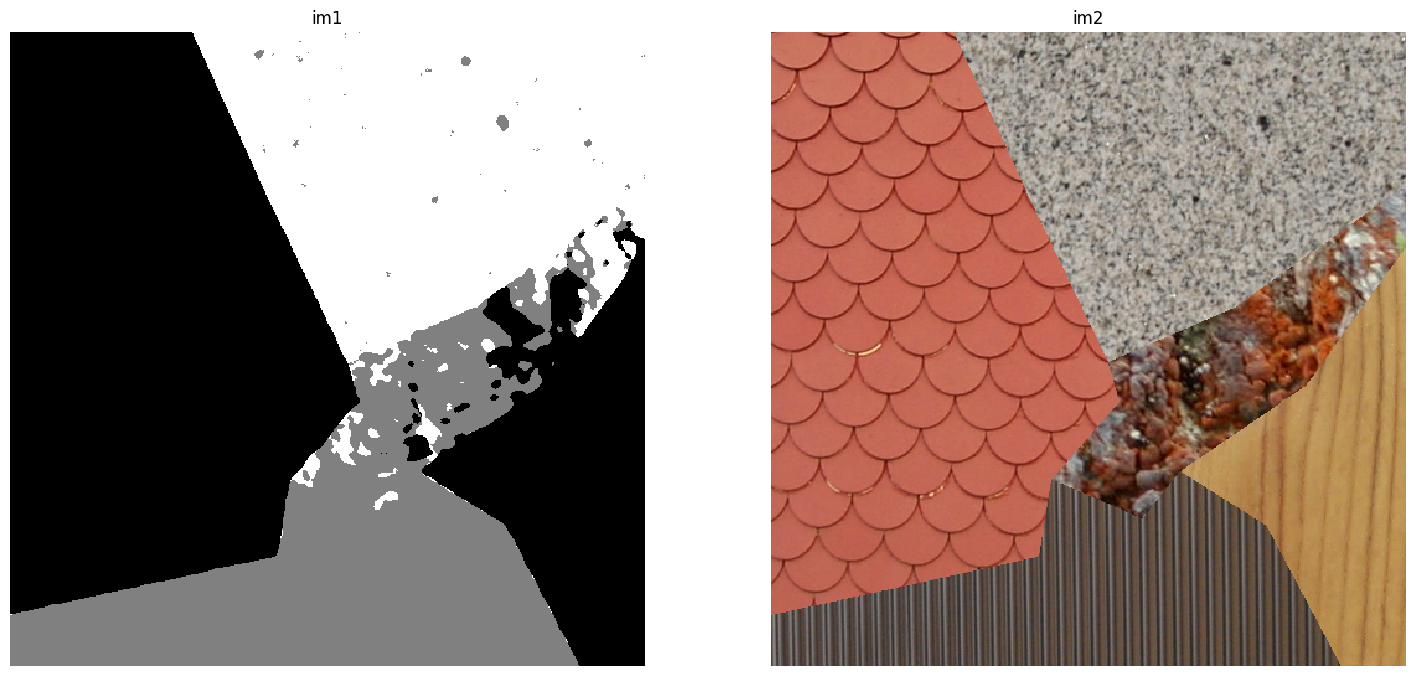

In [55]:
plot_comparison(labels,imgs[2])

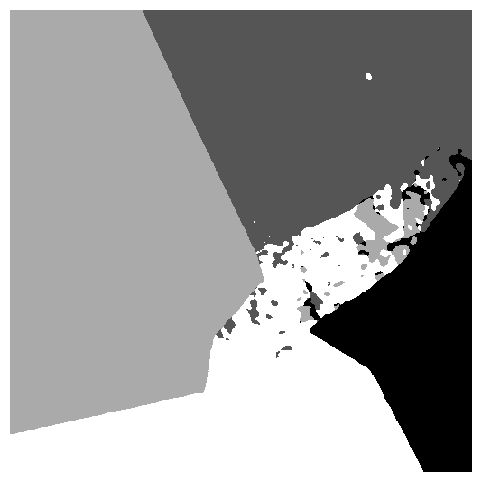

In [61]:
X = []
for channel in img_NS_aug:
    g_T = uniform_filter(channel[0])
    X.append(np.where(channel[1]<=gamma,channel[0],g_T))
    #rajoute les coordonnées du pixel
l_i = np.array([i for i in range(w) for j in range(h)]).reshape((w,h))/w
l_j = np.array([j for i in range(w) for j in range(h)]).reshape((w,h))/h
X.append(l_i)
X.append(l_j)
X = np.dstack(X)
best_K, score = find_optimal_K(X, range(2, 8))
labels2, centers, _ = c_kmeans(X, best_K)
imview(labels2)

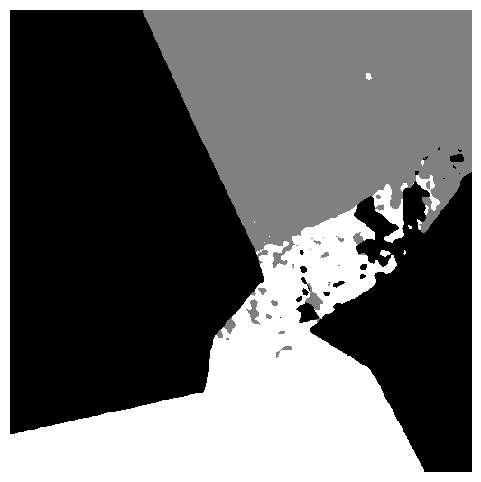

In [59]:
imview(labels2)

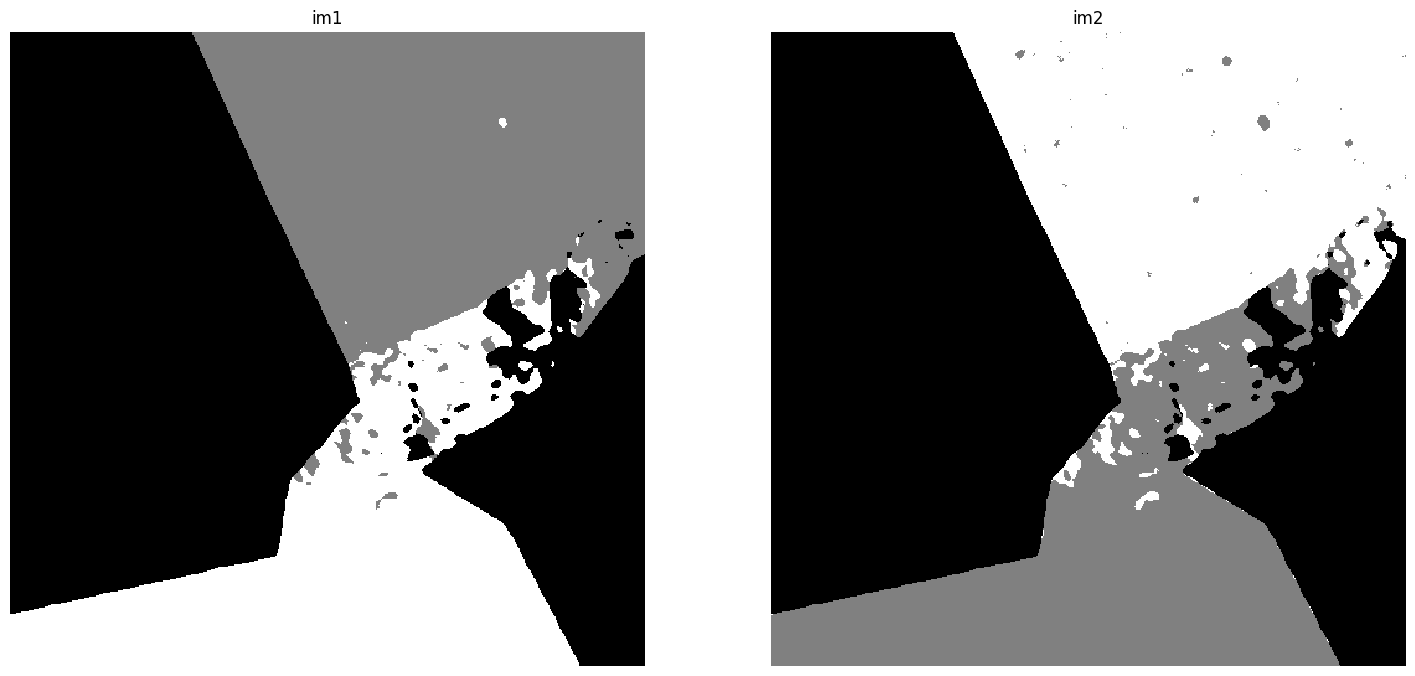

In [58]:
plot_comparison(labels2,labels)

In [13]:
l_i = np.array([i for i in range(w) for j in range(h)]).reshape((w,h))
l_j = np.array([j for i in range(w) for j in range(h)]).reshape((w,h))

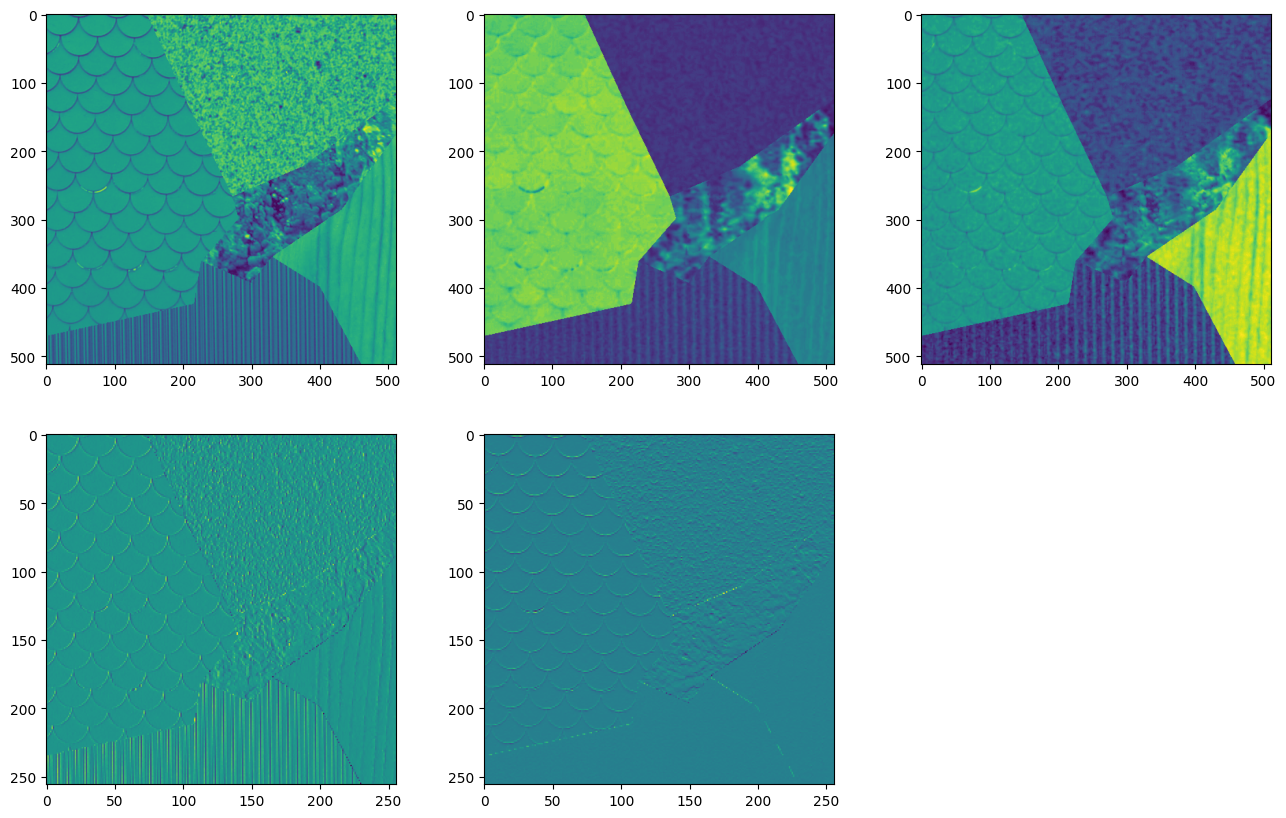

In [8]:
l = [L,u,v,HL,LH]
plt.figure(figsize=(16,10))
for i in range(5):
    plt.subplot(2,3,i+1)
    # plt.imshow(img_NS[i][2])
    plt.imshow(l[i])

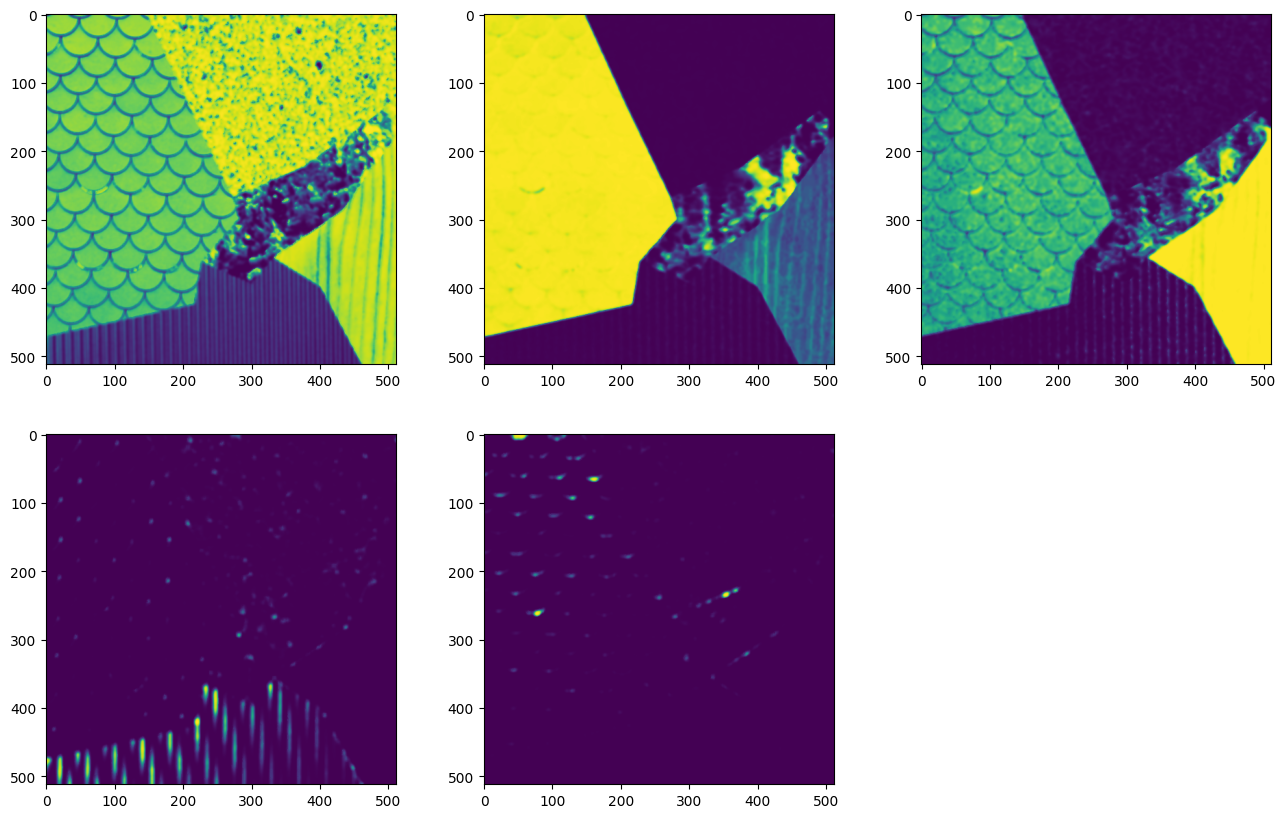

In [9]:
plt.figure(figsize=(16,10))
for i in range(5):
    plt.subplot(2,3,i+1)
    plt.imshow(X[:,:,i])

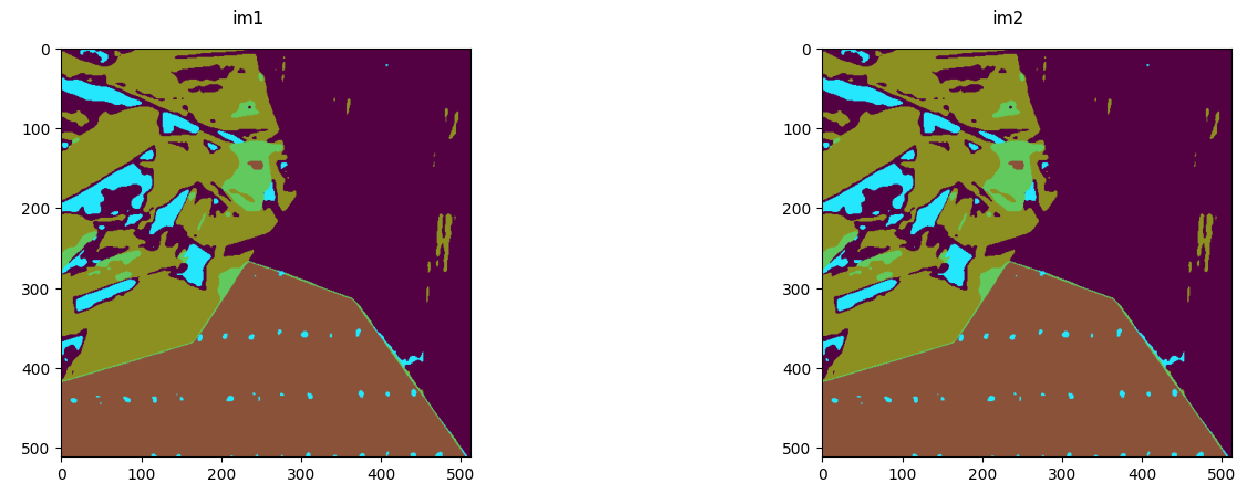

In [23]:
plot_comparison(cv2.imread(f"data/segmentation/labels_model{num_model}.png"),cv2.imread(f"data/segmentation/model_1.png"))

True

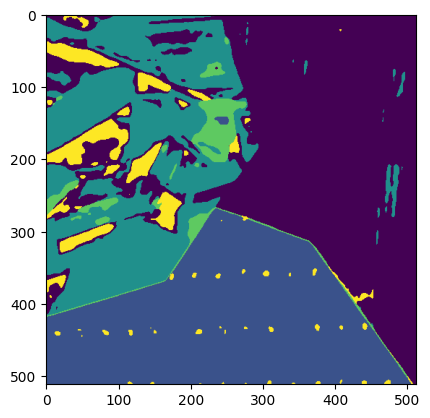

In [14]:
with(open(f"data/segmentation/features_{num_model}.pkl",'wb')) as file:
    pkl.dump(X,file)
plt.imshow(labels)
cv2.imwrite(f"data/segmentation/labels_model{num_model}.png",labels)

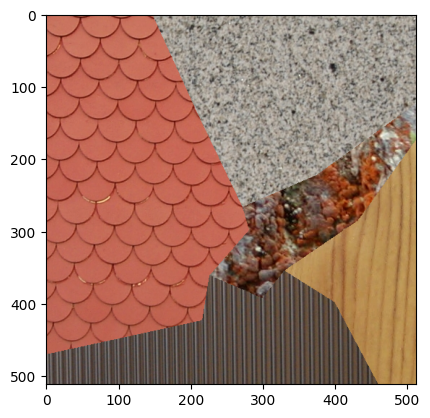

In [19]:
plt.imshow(imgs[2])

In [28]:
np.unique(labels)

array([0, 1, 2, 3, 4], dtype=int32)

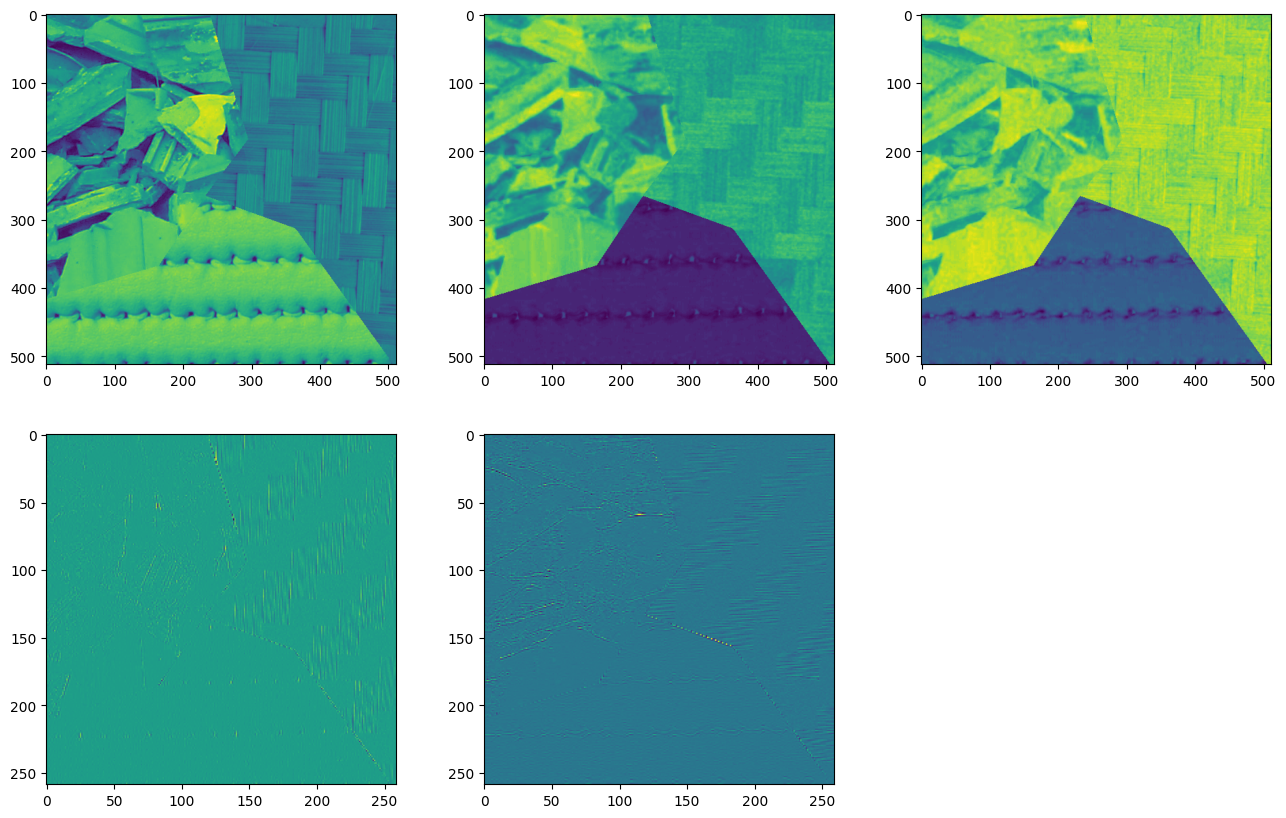

In [37]:
# l = [L,u,v,MEHL,MELH]
l = [L,u,v,HL,LH]
plt.figure(figsize=(16,10))
for i in range(5):
    plt.subplot(2,3,i+1)
    # plt.imshow(img_NS[i][2])
    plt.imshow(l[i])

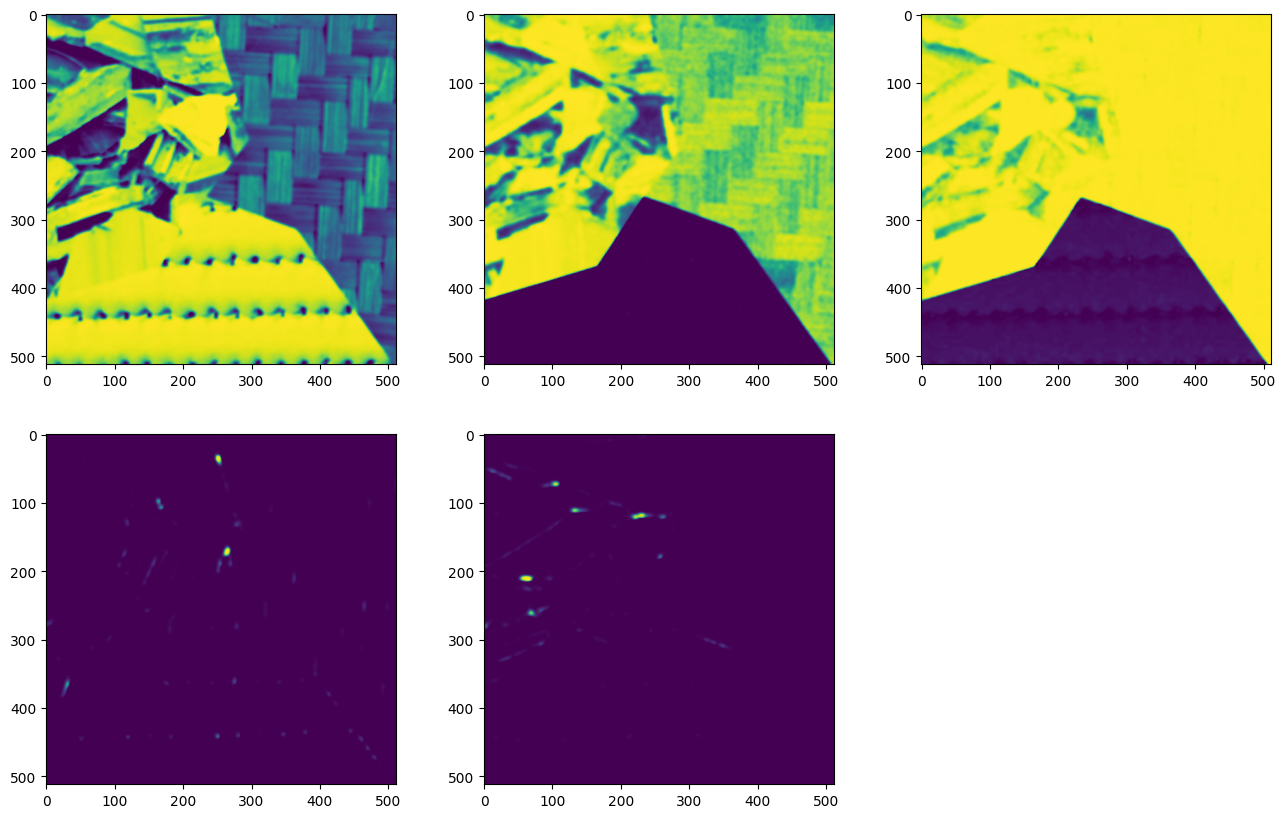

In [17]:
plt.figure(figsize=(16,10))
for i in range(5):
    plt.subplot(2,3,i+1)
    plt.imshow(X[:,:,i])

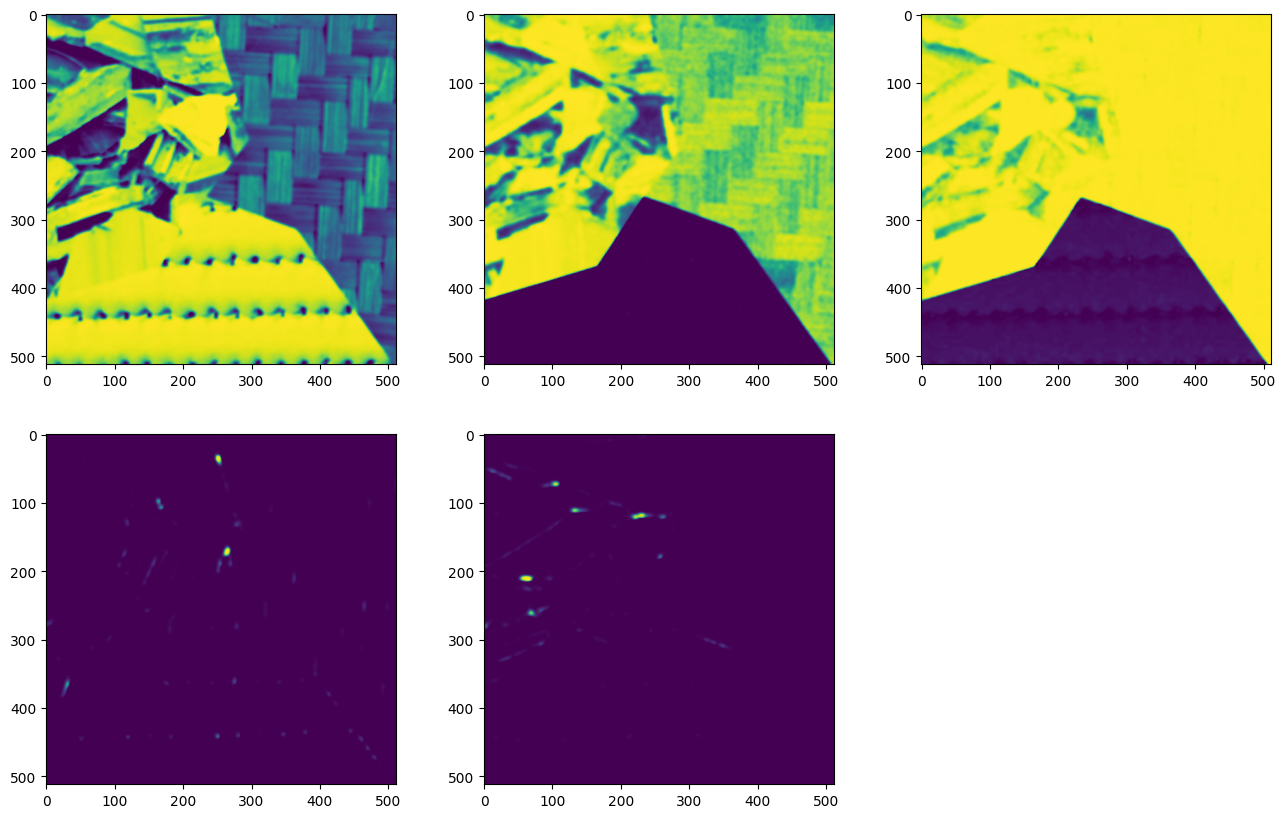

In [18]:
with(open(f"data/segmentation/features_{num_model}.pkl",'rb')) as file:
    X2 = pkl.load(file)

plt.figure(figsize=(16,10))
for i in range(5):
    plt.subplot(2,3,i+1)
    plt.imshow(X2[:,:,i])

Remarques :
LH et HL, ajout de HH ? détails diagonaux - > quand je prends la moyenne est-ce que zone change
-> ces termes on un impact sur le clustering?
à quels point les L, U et V on un impact
pourquoi L ressemble quasiment à image, on dirait que transformation dans NS pas vrm d'effet

## Multi Otsu

In [9]:
seg_imgs = []
for img in imgs:
    smth_img = skimage.filters.median(img)
    threshs = skimage.filters.threshold_multiotsu(smth_img)
    seg = np.digitize(img,bins=threshs)
    # mask = np.zeros(seg.shape)
    # for i in range(len(threshs)):
    #     contours = skimage.measure.find_contours(seg,level=i)
    #     for contour in contours:
    #         mask[contour.astype(np.int32)] += 1
    seg = skimage.morphology.closing(seg)
    mask = skimage.segmentation.find_boundaries(seg)
    seg_imgs.append(mask)

fig, axes = plt.subplots(ncols=3)
idx = np.random.randint(0,20)
axes[0].imshow(seg_imgs[idx], cmap='inferno')
axes[1].imshow(masks[idx])
axes[2].imshow(imgs[idx])

# F1 score
F1 = []
for i in range(len(seg_imgs)):
    TP = np.sum((masks[i] == 1) & (seg_imgs[i] == 1))
    FN = np.sum((masks[i] == 1) & (seg_imgs[i] == 0))
    FP = np.sum((masks[i] == 0) & (seg_imgs[i] == 1))


    F1.append(2*TP / (2*TP + FP + FN))

print(f'Mean accuracy : {np.mean(F1)}')
print(f'Accuracy std : {np.std(F1)}')


/tmp/ipykernel_7169/2255278212.py:4: UserWarning: threshold_multiotsu is expected to work correctly only for grayscale images; image shape (512, 512, 3) looks like that of an RGB image.
  threshs = skimage.filters.threshold_multiotsu(smth_img)


ValueError: operands could not be broadcast together with shapes (512,512) (512,512,3) 

Error in callback <function _draw_all_if_interactive at 0x7313c8915bc0> (for post_execute), with arguments args (),kwargs {}:


ValueError: arrays must be of dtype byte, short, float32 or float64

ValueError: arrays must be of dtype byte, short, float32 or float64

<Figure size 640x480 with 3 Axes>

## SLIC

Mean accuracy : 0.0
Accuracy std : 0.0


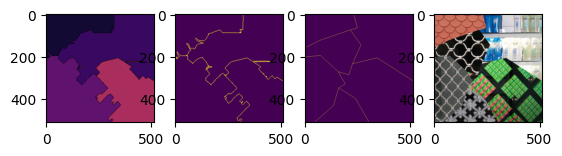

In [ ]:
from skimage.segmentation import slic

seg_imgs = []
seg_masks = []
for img in imgs:

    segments = slic(img,n_segments = 10,compactness = 20)
    # segments = slic(img,n_segments = 10,compactness = 10,channel_axis=None)
    mask = skimage.segmentation.find_boundaries(segments)
    seg = skimage.measure.label(mask,background=1)
    seg_imgs.append(seg)
    seg_masks.append(mask)

# F1 score
F1 = []
for i in range(len(seg_imgs)):
    true_mask = skimage.morphology.dilation(masks[i],skimage.morphology.disk(3))
    pred_mask = skimage.morphology.dilation(seg_imgs[i],skimage.morphology.disk(3))
    TP = np.sum((true_mask == 1) & (pred_mask == 1))
    FN = np.sum((true_mask == 1) & (pred_mask == 0))
    FP = np.sum((true_mask == 0) & (pred_mask == 1))


    F1.append(2*TP / (2*TP + FP + FN))

print(f'Mean F1 : {np.mean(F1)}')
print(f'F1 std : {np.std(F1)}')

fig, axes = plt.subplots(ncols=4)
idx = np.random.randint(0,20)
axes[0].imshow(seg_imgs[idx], cmap='inferno')
axes[1].imshow(seg_masks[idx])
axes[2].imshow(masks[idx])
axes[3].imshow(imgs[idx])